<a href="https://colab.research.google.com/github/Ariara61/ESAA/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_127~154.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Chapter3. 분류**
# 3.1 MNIST
* MNIST: 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 데이터셋

In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version = 1, as_frame = False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* 데이터셋을 설명하는 DESCR 키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
* 레이블 배열을 담은 target 키

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

* 이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있음. (이미지가 28 x 28 픽셀이기 때문.)
* 개개의 특성은 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냄.

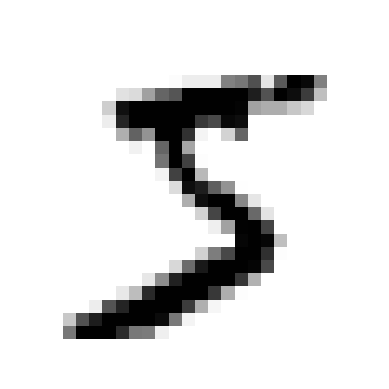

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

In [7]:
# y를 정수로 변환
y = y.astype(np.uint8)

In [8]:
# 항상 테스트 세트를 만들고 따로 떼어놓아야 함
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련
* 이진 분류기(binary classifier): 두 개의 클래스를 구분할 수 있음

In [9]:
# 분류 작업을 위해 타깃 벡터 생성
y_train_5 = (y_train == 5)    # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

* 확률적 경사 하강법(Stochastic Gradient Descent): 한 번에 하나씩 훈련 샘플을 독립적으로 처리하여 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지니고 있음.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 성능 측정
**3.3.1 교차 검증을 사용한 정확도 측정**
* 교차 검증 구현

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


* StratifiedKFold: 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행. 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦. 그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력.

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

* 모든 교차 검증 폴드에 대해 정확도(accuracy)가 95% 이상

In [14]:
# 모든 이미지를 "5 아님" 클래스로 분류하는 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y = None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype = bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

* 이미지의 10% 정도만 숫자 5이기 때문에 무조건 "5 아님"으로 예측하면 정확히 맞출 확률이 90%.
* 불균형 데이터셋을 다룰 때 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유.

**3.3.2 오차 행렬**
* 분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬(confusion matrix)를 조사하는 것

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

* cross_val_score() 함수처럼 cross_val_predict() 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함. 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됨

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* 실제 클래스: 오차 행렬의 행
* 예측한 클래스: 오차 행렬의 열
* 음성 클래스(negative class): 첫번째 행
 * 진짜 음성(true negative): 정확하게 분류
 * 거짓 양성(false positive): 잘못 분류
* 양성 클래스(positivie class): 두번째 행
 * 거짓 음성(false negative): 잘못 분류
 * 진짜 양성(true positive): 정확하게 분류

* 완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주대각선만 0이 아닌 값이 됨

In [18]:
y_train_perfect_predictions = y_train_5    # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

* 정밀도(precision): $\frac{TP}{TP + FP}$
 * TP: 진짜 양성의 수
 * FP: 거짓 양성의 수

* 재현율(recall), 민감도(sensitivity), 진짜 양성 비율(true positive): $\frac{TP}{TP + FN}$
 * FN: 거짓 음성의 수

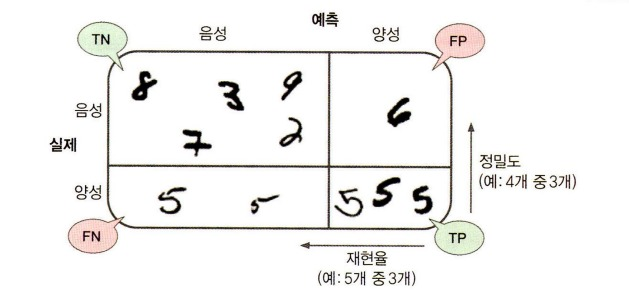

**3.3.3 정밀도와 재현율**

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)    # == 4096 / (4096 + 1522)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)    # == 4096 / (4096 + 1325)

0.6511713705958311

* F1 점수(F1 score): 정밀도와 재현율의 조화 평균(harmonic mean)

$F1 =  \frac{2}{ \frac{1}{정밀도} +  \frac{1}{재현율}  } = 2  \times  \frac{정밀도  \times 재현율}{정밀도 + 재현율} =  \frac{TP}{TP +  \frac{FN + FP}{2} }   $

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

* F1 점수가 항상 바람직한 것은 아니며, 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있음.

**3.3.4 정밀도/재현율 트레이드오프**
* SDGClassifier은 결정 함수(decision function)를 사용하여 각 샘플의 점수를 계산함.
* 이 점수가 임계값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당함
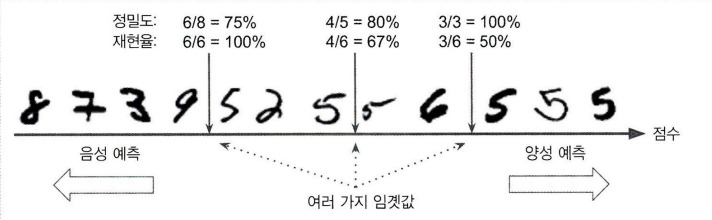

* 사이킷런에서 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있음
* 분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있음. 이 점수를 기반으로 원하는 임계값을 정해 예측을 만들 수 있음.

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

* 임곗값을 높이면 재현율이 줄어들음
* 적절한 임곗값을 정하기 위해서는 cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 함
* 하지만 이번에는 예측 결과가 아니라 결정 점수를 반환받도록 지정해야 함

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

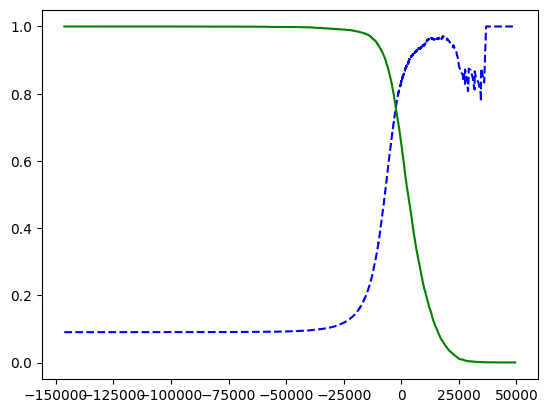

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label = "정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label = "재현율")
  [...]    # 임곗값을 표시하고 범례, 축 이름, 그리드를 추가합니다.

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

* 정밀도가 급격하게 줄어들기 시작하는 점을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

**3.3.5 ROC 곡선**
* 수신기 조작 특성(ROC): 정밀도/재현율 곡선과 매우 비슷하지만, 정밀도에 대한 재현율 곡선이 아니고 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선
* FPR: 양성으로 잘못 분류된 음성 샘플의 비율. 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율(TNR, 특이도)을 뺀 값
* ROC 곡선: 민감도에 대한 1-특이도 그래프

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

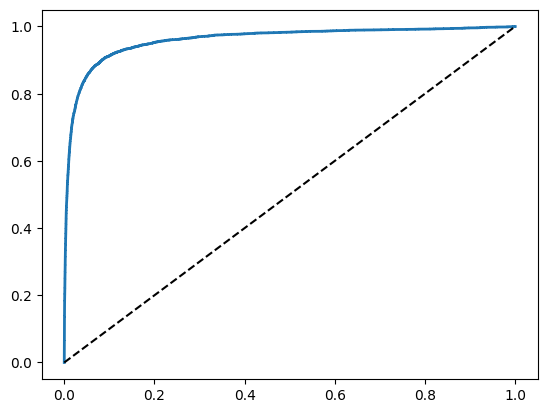

In [33]:
def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0, 1], [0, 1], "k--")    # 대각 점선
  [...]    # 축 이름, 그리드 추가

plot_roc_curve(fpr, tpr)
plt.show()

* 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어남.
* 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함. (왼쪽 위 모서리)
* 곡선 아래의 면적(AUC)
 * 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5임.

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* 양성 클래스가 드물거나 거짓 음성보다 거짓 성이 더 중요할 때 PR 곡선을 사용하고 그렇지 않으면 ROC 곡선을 사용함

* RandomforestClassifier에는 decision_function() 메서드가 없고, 대신 predict_proba() 메서드가 있음
* predict_proba() 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환함

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                    method = "predict_proba")

* roc_curve() 함수는 레이블과 점수를 기대함. 하지만 점수 대신에 클래스 확률을 전달할 수 있음

In [36]:
y_scores_forest = y_probas_forest[:, 1]    # 양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

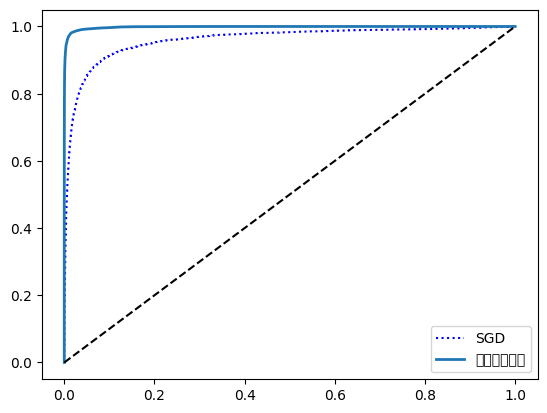

In [37]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤포레스트")
plt.legend(loc = "lower right")
plt.show()

* RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 훨씬 좋아보임.

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 3.4 다중 분류
* 이진 분류가 두 개의 클래스를 구별하는 반면 다중 분류기(multiclass classifier)는 둘 이상의 클래스를 구별할 수 있음.
* (SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 같은) 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면, (로지스틱 회귀나 서포트 벡터 머신 분류기 같은) 다른 알고리즘은 이진 분류만 가능함.
* OvR(one-versus-the-rest):이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하는것
* OvO(one-versus-one): 각 숫자의 조합마다 이진 분류기를 훈련시키는 것. 클래스가 N개라면 분류기는 N x (N-1) / 2개가 필요. 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것이 장점.
* (서포트 벡터 머신 같은) 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호. 하지만 대부분의 이진 분류 알고리즘에서는 OvR을 선호함.


In [39]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)     # y_train_5가 아니고 y_train을 사용합니다.
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [41]:
np.argmax(some_digit_scores)

5

In [42]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
svm_clf.classes_[5]

5

* 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용함.

In [44]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [45]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

* SDG 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요가 없음.

In [46]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

# 3.5 에러 분석

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

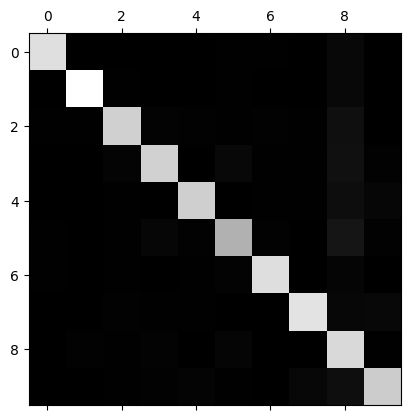

In [50]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

* 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 조임.
* 숫자 5는 다른 숫자보다 조금 더 어두워 보이는데, 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻.
* 오차 행렬의 각 값을 대응되는 이미지 개수로 나누어 에러 비율을 비교함.

In [51]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

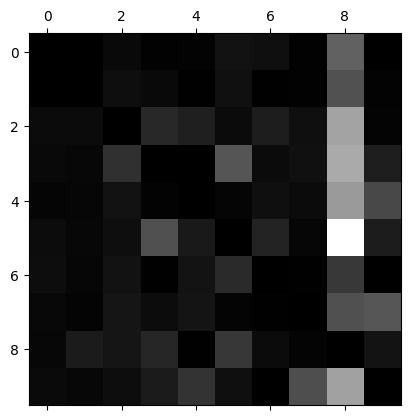

In [52]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

* 클래스의 8열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시함.
* 오차 행렬은 반드시 대칭인 것은 아님.
* 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있음.

In [54]:
# 맷플롯립의 imshow() 사용하는 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

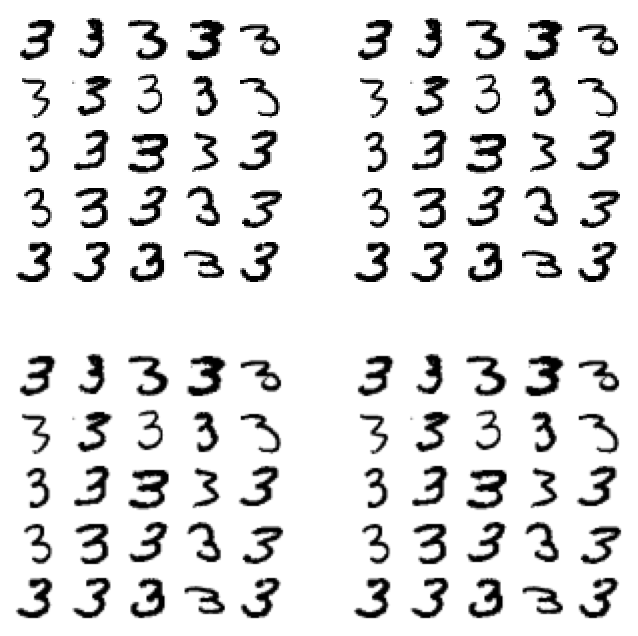

In [55]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_aa[:25], images_per_row = 5)
plt.show()

* 대부분의 잘못 분류된 이미지는 확실히 에러인것 같고 분류기가 실수한 이유를 이해하기 어려움. 원인은 선형 모델인 SGDClassifier을 사용했기 때문.
* 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함. 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨.
* 3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 작은 직선의 위치.
* 분류기는 이미지의 위치나 회전 방향에 매우 민감함. 3과 5의 에러를 줄이는 한가지 방법은 이미지를 중앙에 위치시키고 회전되에 있지 않도록 전처리하는 것.

# 3.6 다중 레이블 분류
* 다중 레이블 분류: 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [56]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [57]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [58]:
# 모든 레이블에 대한 F1 점수의 평균 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.976410265560605

* 레이블에 클래스의 지지도(support)를 가중치로 주려면 average = "weighted"로 설정하면 됨.

# 3.7 다중 출력 분류
* 다중 출력 다중 클래스 분류: 다중 레이블 분류에서 한 레이블의 다중 클래스가 될 수 있도록 일반화한 것

In [61]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [63]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

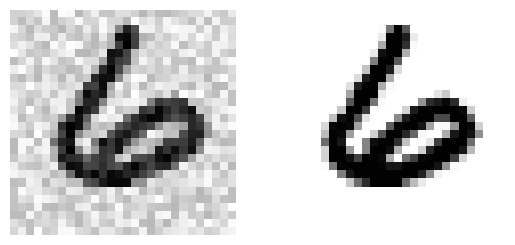

In [64]:
some_index = 5501
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

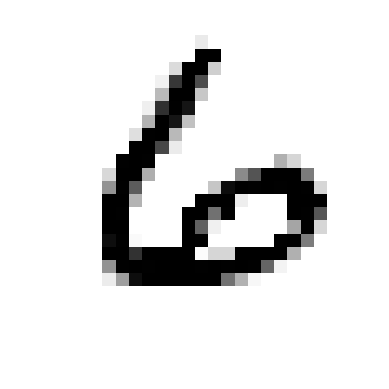

In [65]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)